In [235]:
%matplotlib inline
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine
from pathlib import Path
from tqdm.notebook import tqdm
from collections import defaultdict

def select_model_by_facet_value(facet_value,root=Path("/kbdata/Processed/Models/")):
    models = root.glob(f"*-{facet_value}.w2v.model")
    
    out = {}
    for m in models:
        
        start = m.stem.split('-')[0]
        out[int(start)] = m
        
    return out

cosine_sim = lambda v1,v2: 1 - cosine(v1,v2) 
average_vector = lambda words,model : np.mean([model.wv.__getitem__(w) for w in words if model.wv.__contains__(w)],axis=0)

In [236]:
METADATA_PATH = "../../resources/Lijst_kranten_final.xlsx"
df_meta = pd.read_excel(METADATA_PATH,sheet_name="Sheet1",index_col=0)

In [237]:
df_meta.columns

Index(['PPN', 'Titel Krant', 'Beginjaar', 'Eindjaar', 'Politek', 'Source',
       'Verspreidingsgebied', 'Plaats van uitgave', 'Provincie', 'Zuil'],
      dtype='object')

In [110]:
FEM_PATH = "../../resources/int_vrouw.xlsx"
fem = pd.read_excel(FEM_PATH,sheet_name='Sheet1',index_col=0)

In [111]:
MALE_PATH = "../../resources/int_man.xlsx"
male = pd.read_excel(MALE_PATH,sheet_name='Sheet1',index_col=0)

In [112]:
male.head()

Trefwoord Originele spelling   Woordsoort  Selecteer  monosemy  \
Woordenboek                                                                  
WNT             omweg              OMWEG     znw.(m.)          0       0.0   
WNT            onecht         ONECHT (I)  znw.(v.,m.)          0       0.0   
WNT               oom                OOM     znw.(m.)          1       1.0   
WNT            oorlam             OORLAM  znw.(m.,o.)          1       1.0   
WNT          oppasser           OPPASSER     znw.(m.)          1       1.0   

                                                     Betekenis  
Woordenboek                                                     
WNT                       Eigenlijk, in tweeledige toepassing.  
WNT           znw., oudtijds vr., thans m.; het mv. niet in...  
WNT           Eigenlijk: een broeder des vaders of der moed...  
WNT                     Eigenlijk, als persoonsnaam, en dan m.  
WNT           De persoon die het toezicht op iets houdt; oo...

In [164]:
male_words = [w.lower().split()[0] for w in male[male.monosemy==1].Trefwoord.values]
male_words = male_words + [w.lower().split()[0] for w in male[male.monosemy==1]["Originele spelling"].values]
male_words = list(set(male_words))
female_words = [w.lower().split()[0] for w in fem[fem.monosemy==1].Trefwoord.values]
female_words = female_words + [w.lower().split()[0] for w in fem[fem.monosemy==1]["Originele spelling"].values]
female_words = list(set(female_words))

In [165]:
print(len(female_words),len(male))

340 498


In [169]:
FACET = "Provincie" # "Politek"
FACET_VALUES = df_meta[FACET].unique()
FACET_VALUES


array(['Noord Holland', 'Gelderland', 'Groningen', 'Friesland', 'Drenthe',
       'Zeeland', 'North Brabant', 'South Holland', 'Overijssel',
       'Utrecht', 'Limburg'], dtype=object)

# Timelines

In [170]:
SELECTED_FACETS = ['Neutraal', 'Liberaal','Sociaal-democratisch', 'Katholiek','Protestant']

In [171]:

    

katholiek_models = select_model_by_facet_value('Katholiek')
liberaal_models = select_model_by_facet_value('Liberaal')
years = sorted(set(katholiek).intersection(set(liberaal)))

In [172]:
facet2paths.keys()

dict_keys(['Katholiek', 'Liberaal'])

In [203]:
#target_list = ["schande","beschaamd","beschaamdheid",
#               "beschamen","blaam","blamage","blamatie",
#               "defamatie","diffame","disreputatie","disreputatieus",
#              "disrespect","hoogmoed","hoon","laagheid","lachter","lachteren",
#              "laster","lasteren"]


#target_list = ['kind','kinderen']
target_list = ['schaamte','schamen','schande']
target_list = ['','']

In [204]:
# from gensim.models.word2vec import Word2Vec
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# base_model = "/kbdata/Processed/Models/BaseModel-1800-1909.w2v.model"
# model = Word2Vec.load(base_model)
# print(model)
# model.most_similar('schande')

In [205]:
def compute_bias_average_vector(p1,p2,target,model,metric=cosine_sim):
    """computes bias given two poles and and a target word list
    bias is the average distance of each target word to the poles
    Arguments:
        p1 (list): list of pole words
        p2 (list): lost of pole words
        target (list): list of target words
        metric (funtion): distance function, either cosine or euclidean
    Returns:
        bias (float): the bias score of the target to each of the poles
    """
    av_v1 = average_vector(p1,model); av_v2 = average_vector(p2,model)
    return np.mean([metric(av_v1,model.wv.__getitem__(w)) - \
                      metric(av_v2,model.wv.__getitem__(w)) for w in target 
                           if w in model.wv])

def compute_bias(p1,p2,target,model,metric=cosine_sim):
    p1 = [p for p in p1 if  model.wv.__contains__(p)]
    p2 = [p for p in p2 if  model.wv.__contains__(p)]
    target = [t for t in target if  model.wv.__contains__(t)]
    p1_scores, p2_scores = [],[]
    for t in target:
        for p in p1:
            p1_scores.append(metric(model.wv.__getitem__(p),model.wv.__getitem__(t)))
        for p in p2:
            p2_scores.append(metric(model.wv.__getitem__(p),model.wv.__getitem__(t)))
    return np.mean(p1_scores) - np.mean(p2_scores)

In [208]:
results = {}
for year in tqdm(years):
    lib_model = Word2Vec.load(str(liberaal_models[year]))
    lib_bias = compute_bias(female_words,male_words,target_list,lib_model)
    kath_model = Word2Vec.load(str(katholiek_models[year]))
    kath_bias = compute_bias(female_words,male_words,target_list,kath_model)
    results[year] = (lib_bias,kath_bias)

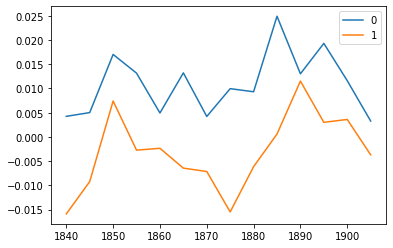

In [209]:
pd.DataFrame(results).T.plot()

# Inspect Scores

In [214]:
def inspect_bias(p1,p2,target,model,metric=cosine_sim):
    p1 = [p for p in p1 if  model.wv.__contains__(p)]
    p2 = [p for p in p2 if  model.wv.__contains__(p)]
    target = [t for t in target if  model.wv.__contains__(t)]
    p1_scores, p2_scores = defaultdict(float),defaultdict(float)
    for t in target:
        for p in p1:
            p1_scores[(p,target[0])] += metric(model.wv.__getitem__(p),model.wv.__getitem__(t))
        for p in p2:
            p2_scores[(p,target[0])] += metric(model.wv.__getitem__(p),model.wv.__getitem__(t))
    return (p1_scores,p2_scores)

In [215]:
#for year in tqdm(years):
YEAR = 1870
lib_model = Word2Vec.load(str(liberaal_models[YEAR]))
lib_bias = inspect_bias(female_words,male_words,target_list,lib_model)
kath_model = Word2Vec.load(str(katholiek_models[YEAR]))
kath_bias = inspect_bias(female_words,male_words,target_list,kath_model)

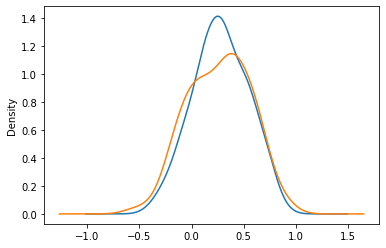

In [216]:
pd.Series(list(lib_bias[0].values())).plot(kind='density')
pd.Series(list(lib_bias[1].values())).plot(kind='density')

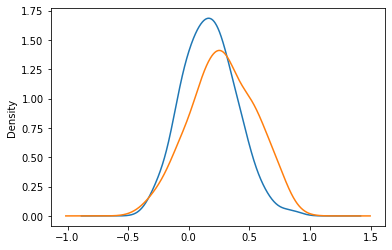

In [217]:
pd.Series(list(kath_bias[0].values())).plot(kind='density')
pd.Series(list(lib_bias[0].values())).plot(kind='density')

In [218]:
sorted(kath_bias[1].items(),key=lambda x: x[1],reverse=True)[:10]

[(('wereld', 'schaamte'), 0.8942476361989975),
 (('reus', 'schaamte'), 0.792017474770546),
 (('bedelaar', 'schaamte'), 0.6962748616933823),
 (('kerel', 'schaamte'), 0.6510880589485168),
 (('staatsman', 'schaamte'), 0.6452149003744125),
 (('grijsaard', 'schaamte'), 0.6266215592622757),
 (('vent', 'schaamte'), 0.6058875471353531),
 (('beschermer', 'schaamte'), 0.6024118214845657),
 (('apostel', 'schaamte'), 0.5853949636220932),
 (('janhagel', 'schaamte'), 0.576781652867794)]

In [219]:
sorted(kath_bias[0].items(),key=lambda x: x[1],reverse=True)[:10]

[(('slavin', 'schaamte'), 0.8419781476259232),
 (('gebiedster', 'schaamte'), 0.6905569732189178),
 (('levensgezellin', 'schaamte'), 0.6079051345586777),
 (('heldin', 'schaamte'), 0.6076409481465816),
 (('meesteres', 'schaamte'), 0.5732857435941696),
 (('burgeres', 'schaamte'), 0.5453149825334549),
 (('xantippe', 'schaamte'), 0.5197172462940216),
 (('waarzegster', 'schaamte'), 0.4985123425722122),
 (('moeder', 'schaamte'), 0.4850379377603531),
 (('tooverheks', 'schaamte'), 0.46100347861647606)]

In [220]:
sorted(lib_bias[0].items(),key=lambda x: x[1],reverse=True)[:10]

[(('zondares', 'schaamte'), 0.8690494447946548),
 (('heldin', 'schaamte'), 0.7696541547775269),
 (('moeder', 'schaamte'), 0.7655677646398544),
 (('matrone', 'schaamte'), 0.7616531699895859),
 (('minnares', 'schaamte'), 0.7438856661319733),
 (('levensgezellin', 'schaamte'), 0.7393519580364227),
 (('vrouw', 'schaamte'), 0.7228668630123138),
 (('meesteres', 'schaamte'), 0.7071087881922722),
 (('voedster', 'schaamte'), 0.7067084461450577),
 (('schoonmoeder', 'schaamte'), 0.6965679228305817)]

# Barplots

In [238]:
FACET = "Politek" # "Politek" | Provincie
FACET_VALUES = df_meta[FACET].unique()
FACET_VALUES

array(['Neutraal', 'Liberaal', nan, 'Sociaal-democratisch', 'Katholiek',
       'Protestant', 'Conservatief'], dtype=object)

In [239]:
YEAR = 1880

selected_models = {}

for facet in FACET_VALUES:
    model_paths = select_model_by_facet_value(facet)
    
    selected_models[facet] = model_paths.get(YEAR,None)
    
selected_models = {w:v for w,v in selected_models.items() if v}

In [240]:
selected_models

{'Neutraal': PosixPath('/kbdata/Processed/Models/1880-1900-Neutraal.w2v.model'),
 'Liberaal': PosixPath('/kbdata/Processed/Models/1880-1900-Liberaal.w2v.model'),
 'Sociaal-democratisch': PosixPath('/kbdata/Processed/Models/1880-1900-Sociaal-democratisch.w2v.model'),
 'Katholiek': PosixPath('/kbdata/Processed/Models/1880-1900-Katholiek.w2v.model'),
 'Protestant': PosixPath('/kbdata/Processed/Models/1880-1900-Protestant.w2v.model')}

In [241]:
results = {}
for w,v in tqdm(selected_models.items()):
    model = Word2Vec.load(str(v))
    results[w] = compute_bias(female_words,male_words,target_list,model)

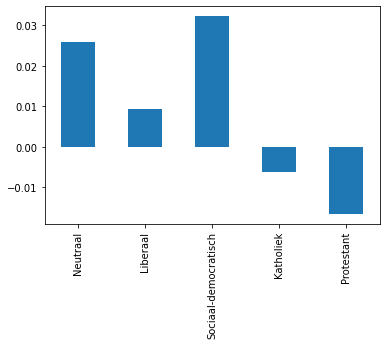

In [242]:
pd.Series(results).plot(kind='bar')